In [182]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score

In [183]:
customers = pd.read_csv('customers_dataset.csv')
print(customers.columns)
geolocation = pd.read_csv('geolocation_dataset.csv')
print(geolocation.columns)
orders = pd.read_csv('orders_dataset.csv')
print(orders.columns)
order_items = pd.read_csv('order_items_dataset.csv')
print(order_items.columns)
products = pd.read_csv('products_dataset.csv')
print(products.columns)
sellers = pd.read_csv('sellers_dataset.csv')
print(sellers.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')
Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')


# Tackling a Big Project with Limited Time: My Plan

### Here's what I’m thinking:
1. **First, I need to understand the problem.**
   The goal is clear: predict delivery dates more accurately to improve customer satisfaction. Right now, unexpected delays are frustrating customers and making them less likely to come back.

2. **Next, I’ll define the target.**
   To do that, I’ll calculate the actual delivery time for each order from the data.

3. **Feature Engineering comes next.**
   I’ll dig into the data to create meaningful features. Things like shipping distances, product sizes, seller and customer locations, and timestamps are probably going to be key. Geolocation data might also add a lot of value.

4. **EDA is important, but I’ll focus it.**
   Let’s be honest—exploratory data analysis (EDA) can take forever. Since time is tight, I’ll zoom in on the target-related variables and the features I created. This won’t be a full-blown EDA, but it’ll be enough to move forward.

5. **Then, I’ll build the model.**
    I plan to use regression models, beginning with the XGBoost Regressor, due to the complex relationships identified during the exploratory data analysis (EDA). Additionally, XGBoost offers excellent explainability. I will optimize the model's parameters and apply cross-validation for robustness. For evaluation, I will use RMSE, as it provides error values in the same unit as the target variable and is sensitive to outliers. Also, use Feature Importance to see the features that contribute the most.

6. **Then, I’ll compare it to the baseline.**
   There’s already a black-box time estimation system in place. I’ll compare my model’s predictions to see if we’re really making things better.

7. **Finally, I will add the predictions to the purchase date to create the estimated delivery date, as requested.**

### That’s my approach—focused and prioritized to make the most of the time I’ve got.


In [184]:
# So lets start with combination of EDA and feature engineering:
# some data cleaning-outliers, nans, duplicates etc.., understanding distributions, and creating cool features
# if i would have more time i will look into the missing values more carefully to try to find a pattern there.

In [185]:
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# this is the target
orders['actual_delivery_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

orders = orders.dropna(subset=['actual_delivery_days'])
percentile_99 = np.percentile(orders['actual_delivery_days'], 99)
orders = orders[orders['actual_delivery_days'] <= percentile_99]

orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])

orders['purchase_approve_days'] = (orders['order_approved_at'] - orders['order_purchase_timestamp']).dt.days
orders['approve_delivery_days'] = (orders['order_delivered_carrier_date'] - orders['order_approved_at']).dt.days

# Late deliveries are those delivered after the estimated date
orders['is_late'] = (orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']).astype(int)

# Temporal Features:
orders['order_day_of_week'] = orders['order_purchase_timestamp'].dt.day_name()
orders['order_hour'] = orders['order_purchase_timestamp'].dt.hour

order_items = order_items.merge(
    orders[['order_id', 'customer_id', 'order_day_of_week', 'order_hour', 'is_late', 'purchase_approve_days', 'approve_delivery_days', 'actual_delivery_days']],
    on='order_id')


In [186]:
customers.drop_duplicates(
    subset=['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state'],
    inplace=True
)

geolocation = geolocation.groupby(['geolocation_zip_code_prefix']).last().reset_index()

customers = customers.merge(geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
customers = customers.rename(columns={
    'geolocation_lat': 'geolocation_lat_customer',
    'geolocation_lng': 'geolocation_lng_customer',
    'geolocation_city': 'geolocation_city_customer',
    'geolocation_state': 'geolocation_state_customer'
})

In [187]:
sellers = sellers.merge(geolocation, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
sellers = sellers.rename(columns={
    'geolocation_lat': 'geolocation_lat_seller',
    'geolocation_lng': 'geolocation_lng_seller',
    'geolocation_city': 'geolocation_city_seller',
    'geolocation_state': 'geolocation_state_seller'
})

In [188]:
# Geographic Features:
def calculate_distance(row, sellers_geo, customers_geo):
    seller_coords = sellers_geo.get(row['seller_id'])
    customer_coords = customers_geo.get(row['customer_id'])
    return geodesic(seller_coords, customer_coords).km if seller_coords and customer_coords else None

sellers.dropna(subset=['geolocation_lat_seller', 'geolocation_lng_seller'], inplace=True)
customers.dropna(subset=['geolocation_lat_customer', 'geolocation_lng_customer'], inplace=True)

sellers_geo = sellers.set_index('seller_id')[['geolocation_lat_seller', 'geolocation_lng_seller']].apply(tuple, axis=1).to_dict()
customers_geo = customers.set_index('customer_id')[['geolocation_lat_customer', 'geolocation_lng_customer']].apply(tuple, axis=1).to_dict()
order_items['distance_km'] = order_items.apply(lambda row: calculate_distance(row, sellers_geo, customers_geo), axis=1)

order_items = order_items.merge(sellers[['seller_id', 'seller_city', 'seller_state']],
                                on='seller_id', how='left')
order_items = order_items.merge(customers[['customer_id', 'customer_city', 'customer_state']],
                                on='customer_id', how='left')

In [189]:
# Order Features:
# Number of items in the order.
order_items['item_count'] = order_items.groupby('order_id')['product_id'].transform('count')
# Total price of the order.
order_items['total_price'] = order_items.groupby('order_id')['price'].transform('sum')
# Total price of the freight of the order.
order_items['total_freight_price'] = order_items.groupby('order_id')['freight_value'].transform('sum')
# Weight and dimensions of items (from the product dataset).
order_items = order_items.merge(products[['product_id', 'product_category_name', 'product_weight_g', 'product_length_cm',
                                          'product_height_cm', 'product_width_cm']],
                                on='product_id', how='left')
order_items['product_volume_cm3'] = (order_items['product_length_cm'] *
                                     order_items['product_height_cm'] *
                                     order_items['product_width_cm'])
# Total weight of the order.
order_items['total_weight'] = order_items.groupby('order_id')['product_weight_g'].transform('sum')

In [190]:
# Seller Performance:
# Average delivery time for each seller.
seller_performance = order_items.groupby('seller_id')['actual_delivery_days'].mean().reset_index(name='avg_delivery_time')

# Count of late deliveries per seller.
late_deliveries = order_items.groupby('seller_id')['is_late'].sum().reset_index(name='late_deliveries')
# seller_num_products = order_items.groupby('seller_id')['product_id'].nunique().reset_index(name='seller_num_products')

order_items = order_items.merge(late_deliveries, on='seller_id')
order_items = order_items.merge(seller_performance, on='seller_id')

In [191]:
for clean in ['purchase_approve_days', 'approve_delivery_days', 'distance_km', 'total_price', 'total_freight_price', 'product_weight_g']:
    print(clean)
    print(order_items.shape)
    order_items = order_items.dropna(subset=[clean])
    print(order_items.shape)
    percentile_99 = np.percentile(order_items[clean], 99)
    order_items = order_items[order_items[clean] <= percentile_99]
#
print(order_items.shape)
order_items = order_items.dropna(subset=['approve_delivery_days'])
print(order_items.shape)
percentile_01 = np.percentile(order_items['approve_delivery_days'], 1)
order_items = order_items[order_items['approve_delivery_days'] > percentile_01]

purchase_approve_days
(109230, 31)
(109215, 31)
approve_delivery_days
(108364, 31)
(108364, 31)
distance_km
(107382, 31)
(103273, 31)
total_price
(102240, 31)
(102240, 31)
total_freight_price
(101232, 31)
(101232, 31)
product_weight_g
(100223, 31)
(100208, 31)
(99224, 31)
(99224, 31)


In [192]:
numerical_features = [
    'price', 'freight_value', 'purchase_approve_days',
    'approve_delivery_days',
    'distance_km', 'item_count', 'total_price', 'total_freight_price',
    'product_weight_g', 'product_length_cm', 'product_height_cm',
    'product_width_cm', 'product_volume_cm3', 'total_weight',
    'late_deliveries', 'avg_delivery_time'
]

categorical_features = ['order_day_of_week', 'order_hour', 'is_late', 'product_category_name', 'seller_city', 'seller_state', 'customer_city', 'customer_state']

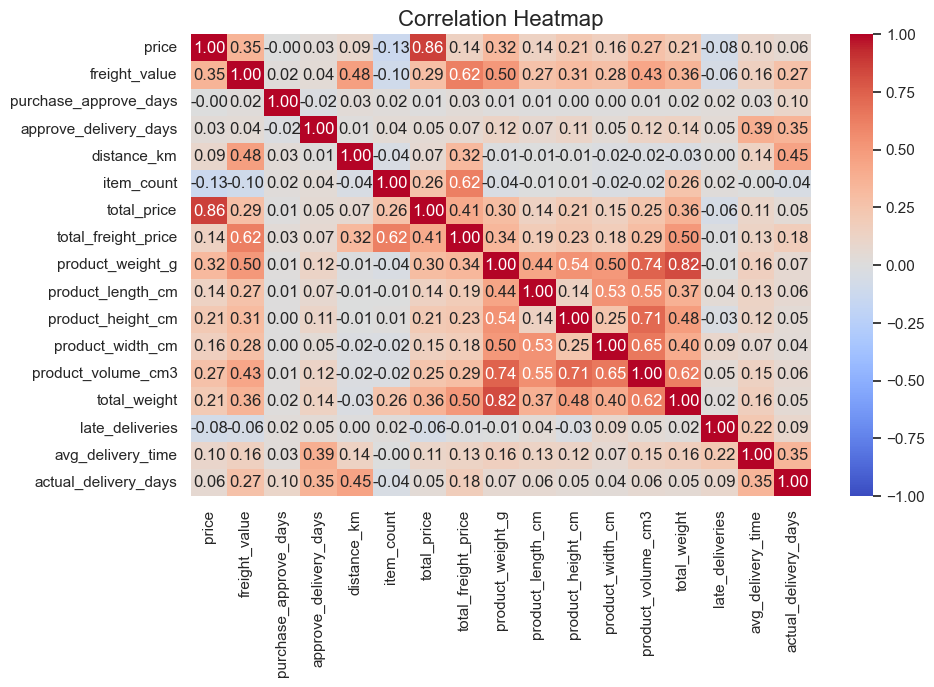

In [198]:
import numpy as np

correlation_matrix = order_items[numerical_features + ['actual_delivery_days']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


In [194]:
# It seems the target variable shows some correlation with the seller's average delivery time, the distance in kilometers, the number of days from approval to delivery, and the freight value.
# Together, these features suggest a narrative about sellers who ship to distant locations and potentially specific sellers who consistently take longer to deliver.

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


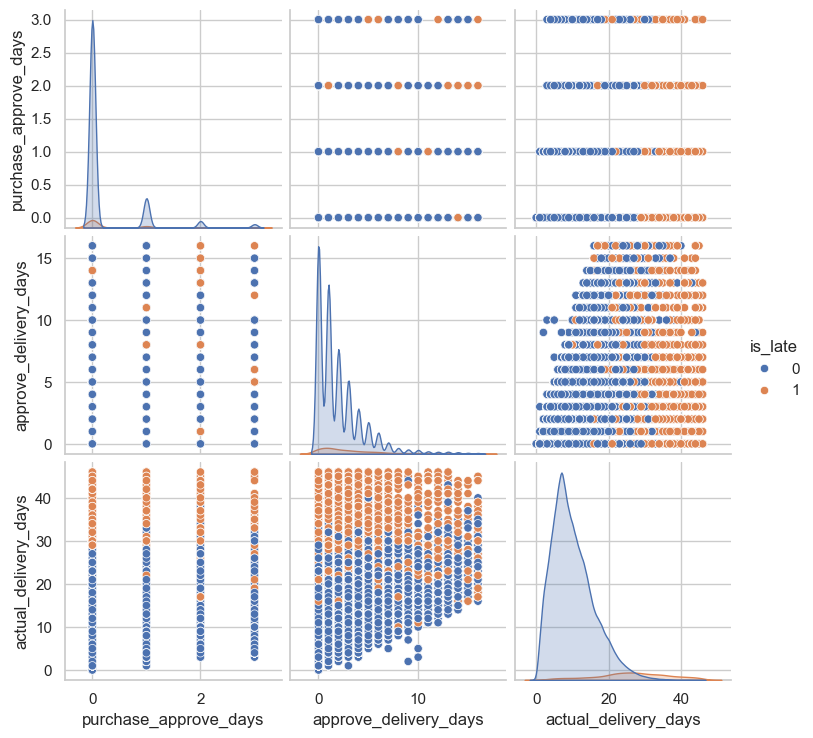

In [195]:
sns.pairplot(order_items, vars=['purchase_approve_days', 'approve_delivery_days'] + ['actual_delivery_days'], diag_kind='kde', kind='scatter', hue='is_late')
plt.show()


In [ ]:
# Here, we observe that higher approval-to-delivery days are associated with longer actual delivery times, while the time elapsed from purchase to approval doesn't seem to have a significant impact.

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


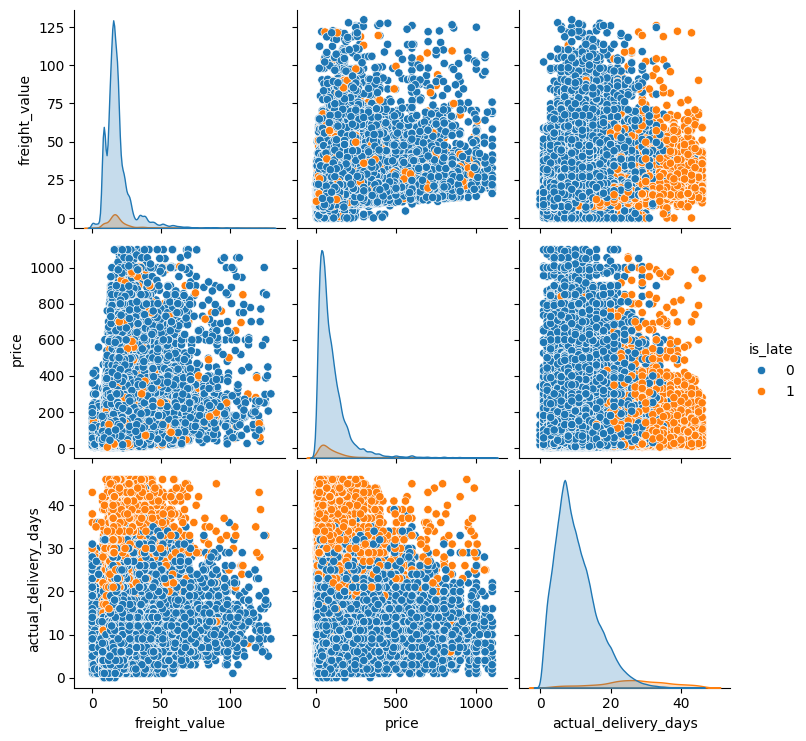

In [71]:
sns.pairplot(order_items, vars=['freight_value', 'price'] + ['actual_delivery_days'], diag_kind='kde', kind='scatter', hue='is_late')
plt.show()


In [ ]:
#Here, we observe that higher prices are associated with fewer late deliveries and shorter delivery times. A similar trend is evident for higher freight values and that cheaper freight values tend to not to be late.

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWa

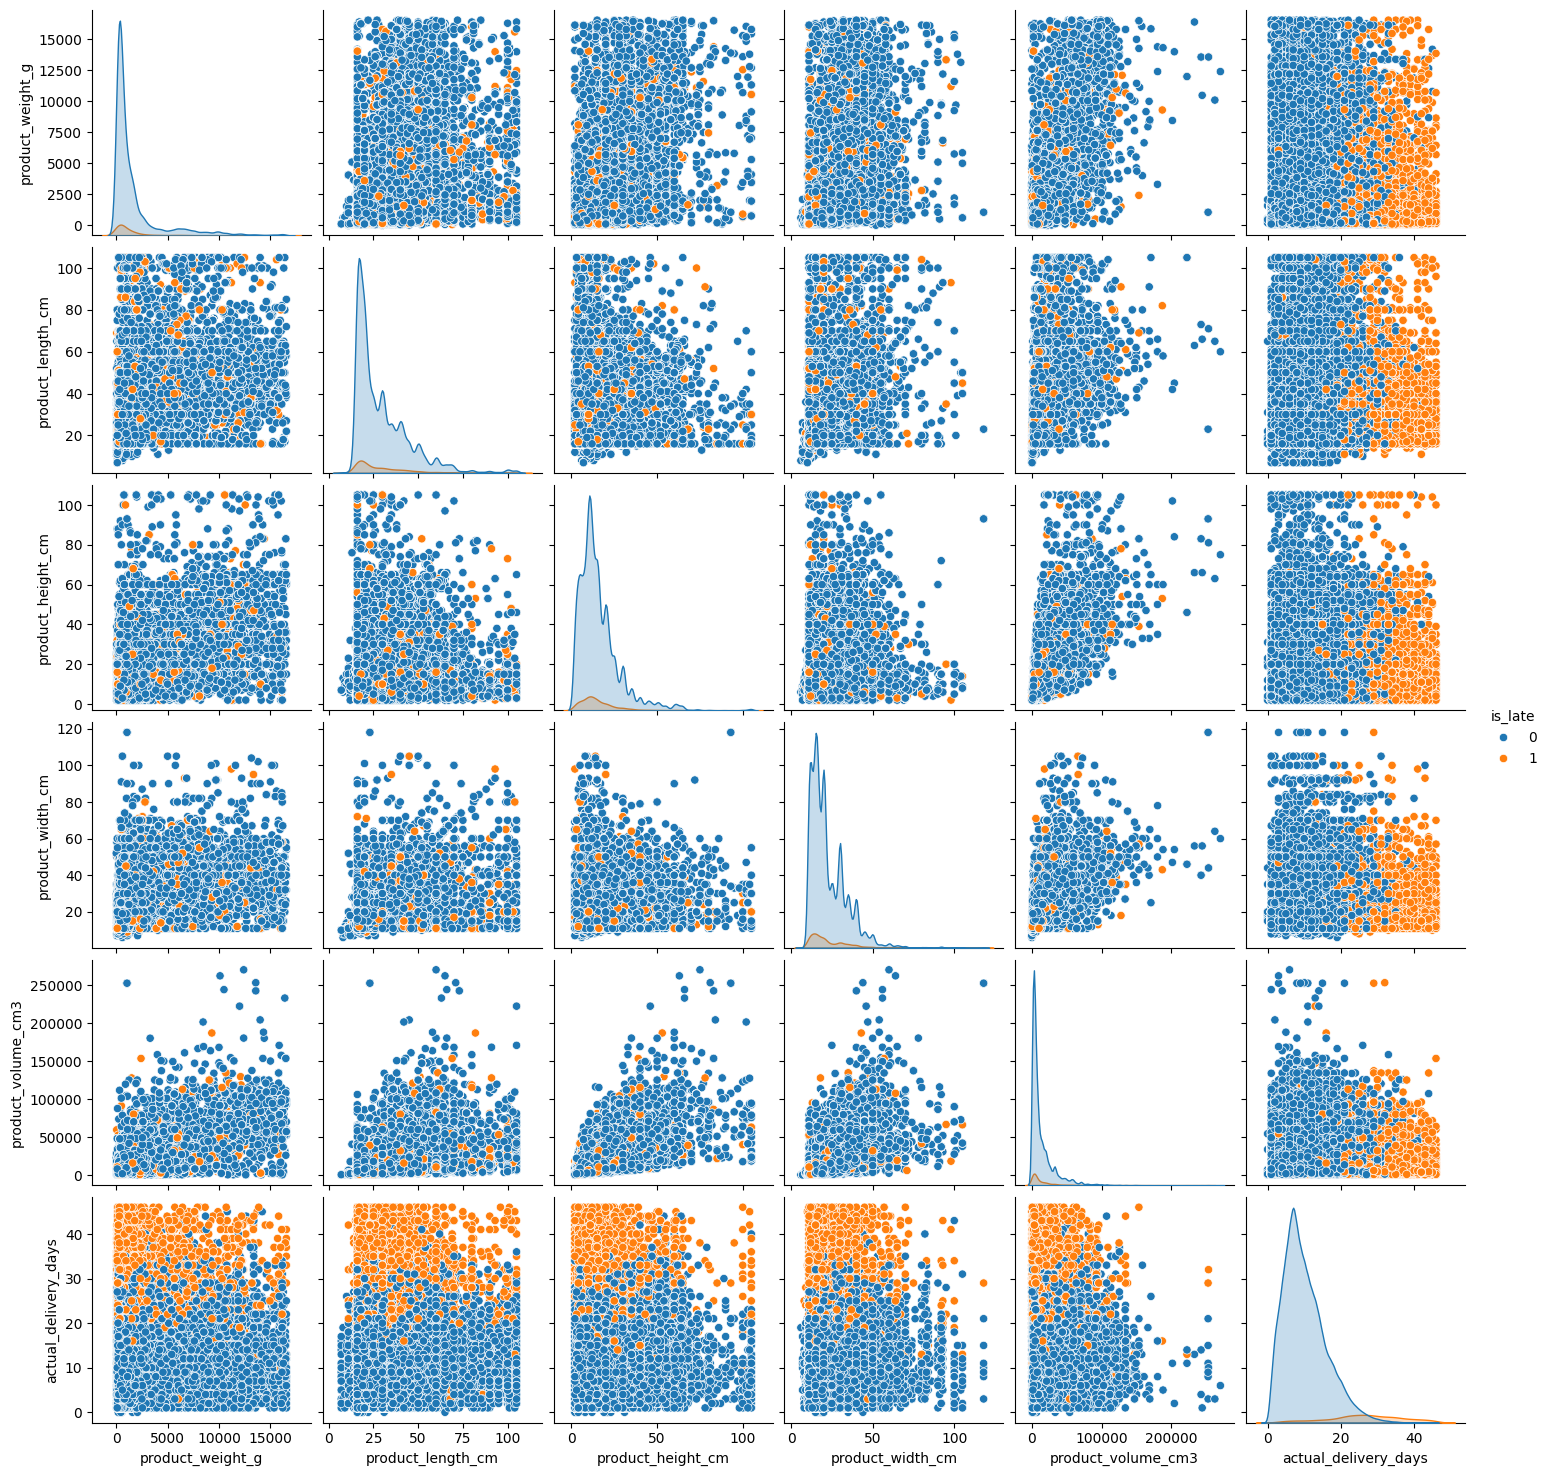

In [72]:
sns.pairplot(order_items, vars=['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_volume_cm3'] + ['actual_delivery_days'], diag_kind='kde', kind='scatter', hue='is_late')
plt.show()

In [ ]:
#Here, we see that the size and shape of the products do impact delivery times.

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWa

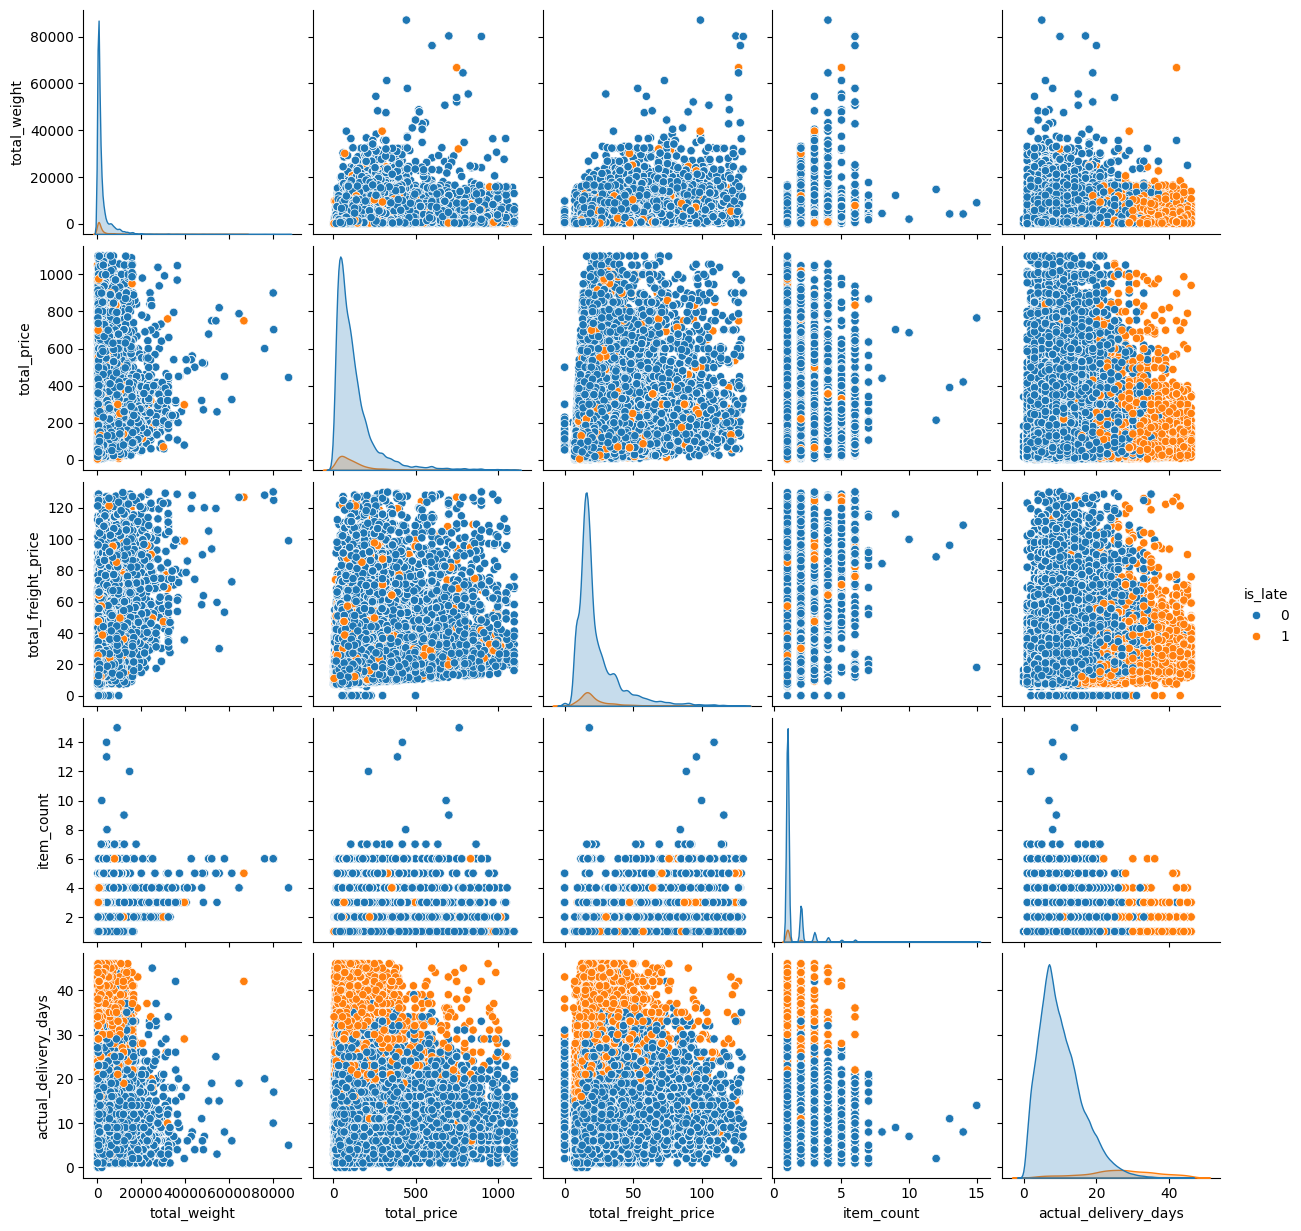

In [73]:
sns.pairplot(order_items, vars=['total_weight', 'total_price', 'total_freight_price', 'item_count'] + ['actual_delivery_days'], diag_kind='kde', kind='scatter', hue='is_late')
plt.show()


In [ ]:
#Here, we see that the total size and shape of the products in an order do not impact delivery times.
# But, the higher the total price and freight price are, the shorter the delivery days, and they tend to late less.

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWa

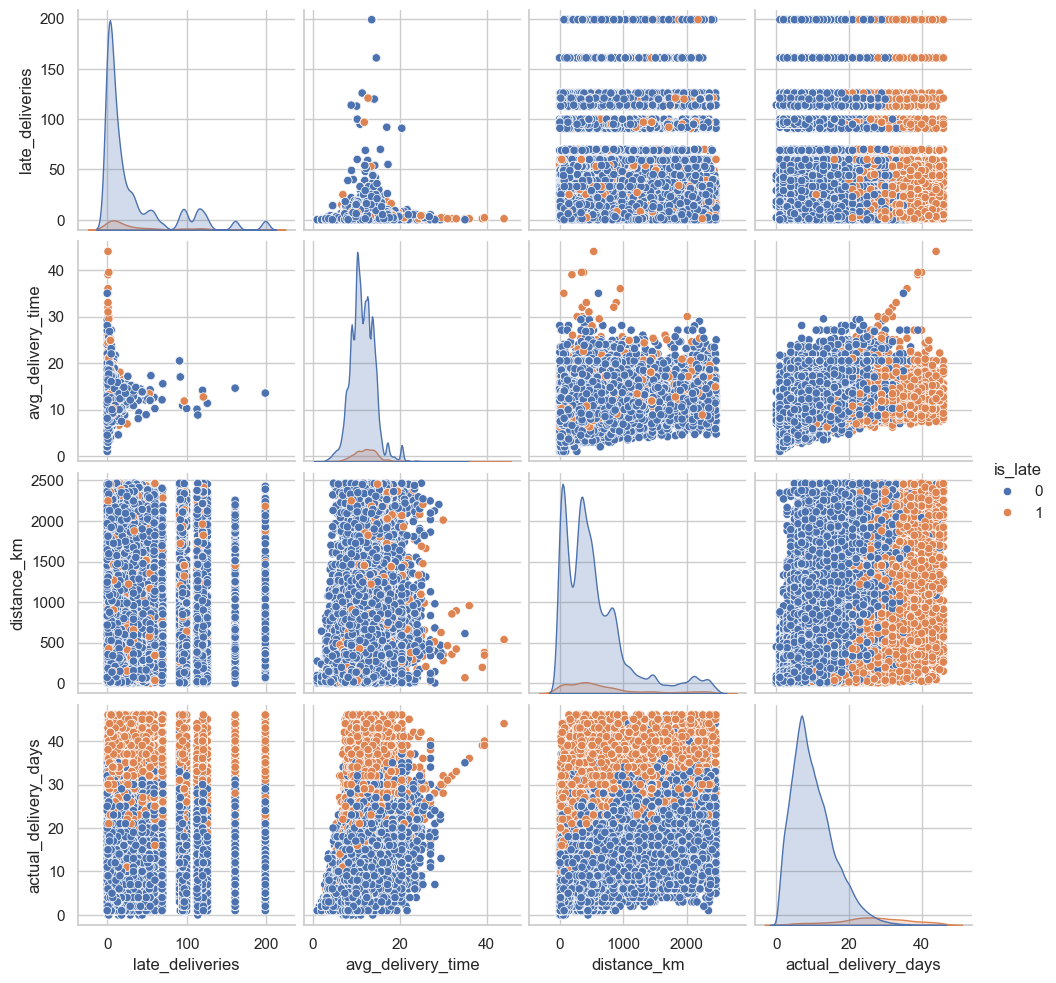

In [196]:
sns.pairplot(order_items, vars=['late_deliveries', 'avg_delivery_time', 'distance_km'] + ['actual_delivery_days'], diag_kind='kde', kind='scatter', hue='is_late')
plt.show()


In [75]:
# Here, we observe that orders sent to more distant locations tend to take longer to arrive. Additionally, there is an interesting correlation between a seller's average delivery time and the likelihood of late deliveries.

/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


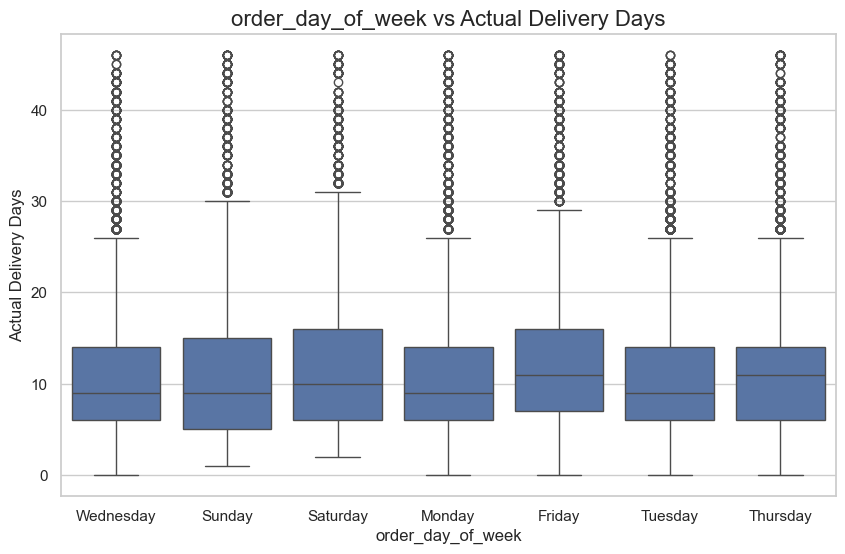

/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


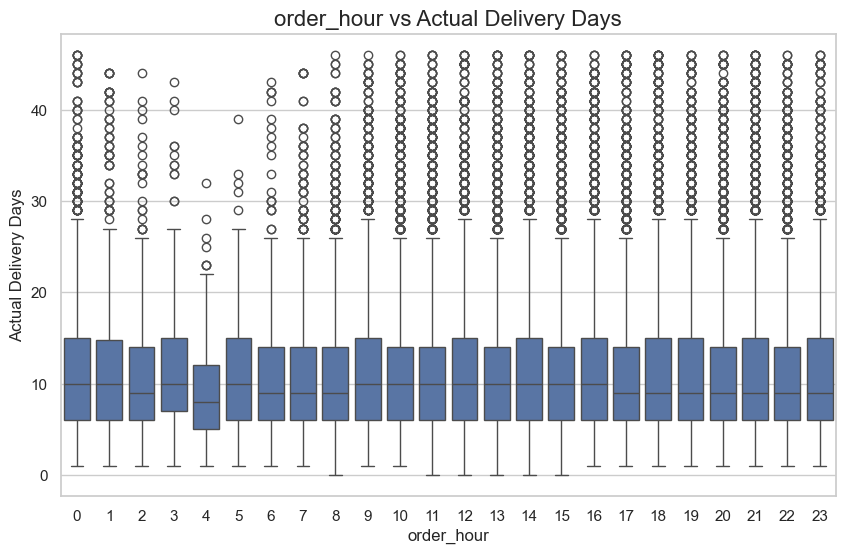

/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


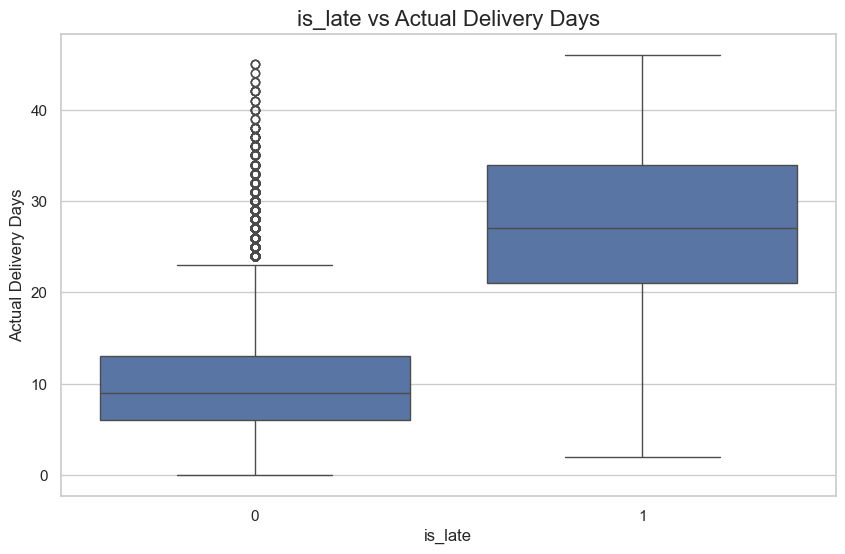

/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


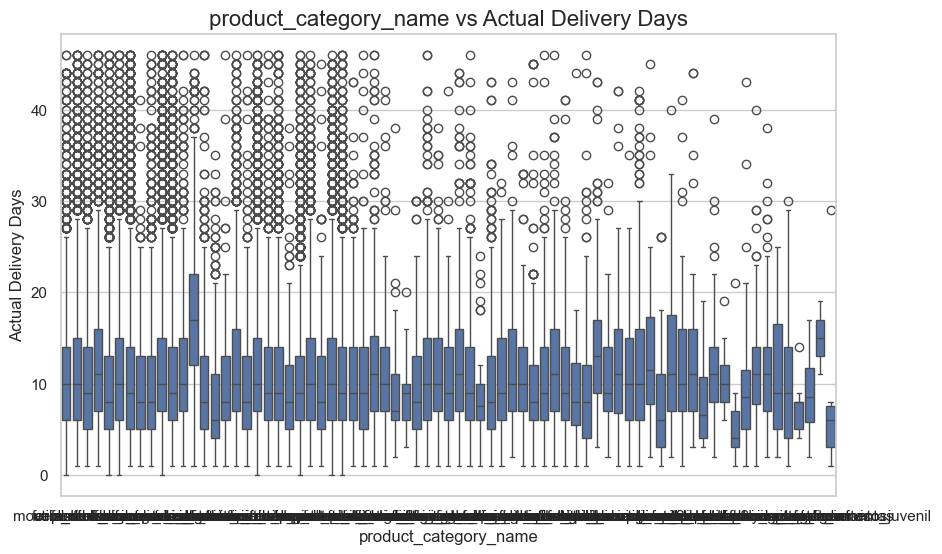

/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


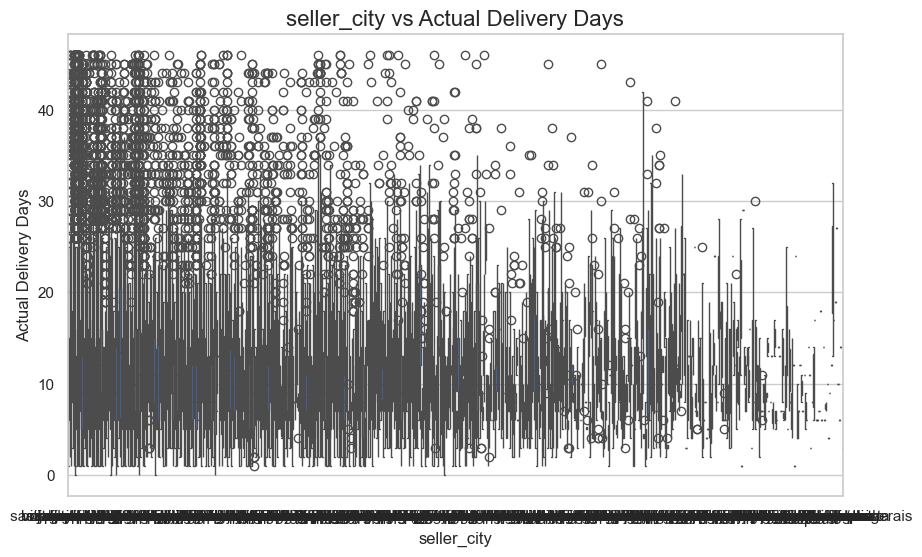

/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


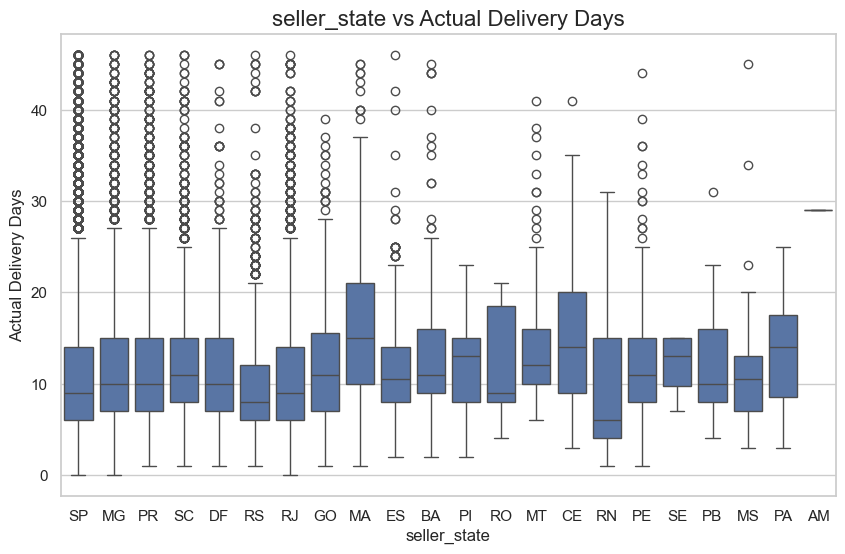

/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


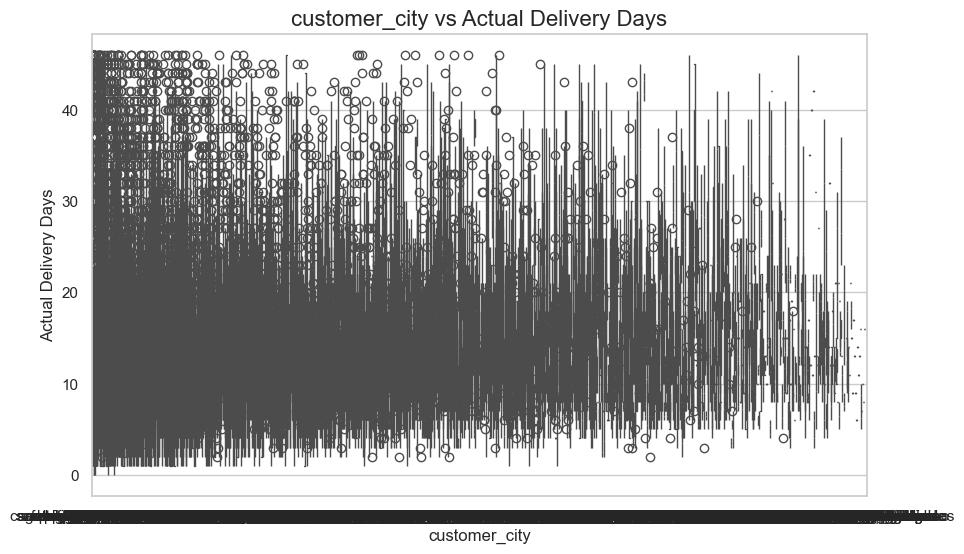

/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


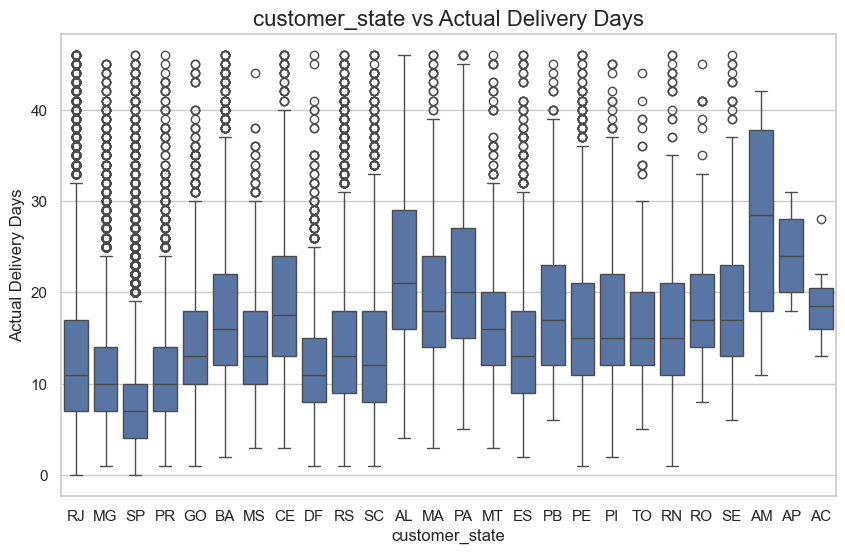

In [133]:
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='actual_delivery_days', data=order_items)
    plt.title(f'{feature} vs Actual Delivery Days', fontsize=16)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Actual Delivery Days', fontsize=12)
    plt.show()


In [ ]:
# there are some product_category_name that has shorter time of delivery (if I would have time, I will make the x axis more readable) and some cities and states that show different distributions, we ca use this later in the recomndation system.
# i will drill down into one example:
#find a product category that usually late: casa_conforto_2 lates 17% of the time

In [136]:
order_items.groupby(['product_category_name'])['is_late'].mean()

product_category_name
agro_industria_e_comercio    0.041916
alimentos                    0.088553
alimentos_bebidas            0.059055
artes                        0.076503
artes_e_artesanato           0.100000
                               ...   
sinalizacao_e_seguranca      0.046053
tablets_impressao_imagem     0.065789
telefonia                    0.074933
telefonia_fixa               0.040724
utilidades_domesticas        0.056488
Name: is_late, Length: 73, dtype: float64

In [143]:
order_items[order_items['product_category_name']=='casa_conforto_2'].groupby(['seller_id'])['avg_delivery_time'].mean()

seller_id
05aebce0b5c8f0d41b29b686f2d05fd3     5.500000
3b15288545f8928d3e65a8f949a28291    13.796610
45d33f715e24d15a6ccf5c17b3a23e3c    10.298246
4a3ca9315b744ce9f8e9374361493884    13.552223
Name: avg_delivery_time, dtype: float64

In [141]:
# It’s clear that a single seller stands out as the main factor contributing to shorter delivery times.
# We could recommend prioritizing purchases from other sellers to help reduce delivery timelines.
# Of course, there are plenty of other factors worth exploring to gain deeper insights( number of orders per seller, avg seller time per distance..).

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


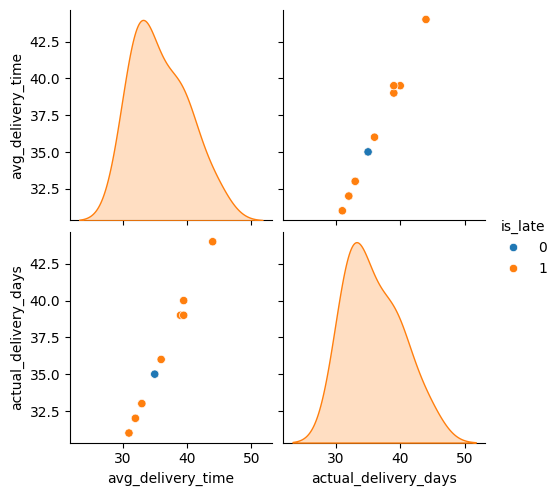

In [83]:
sns.pairplot(order_items[order_items['avg_delivery_time'] > 30], vars=['avg_delivery_time'] + ['actual_delivery_days'], diag_kind='kde', kind='scatter', hue='is_late')
plt.show()


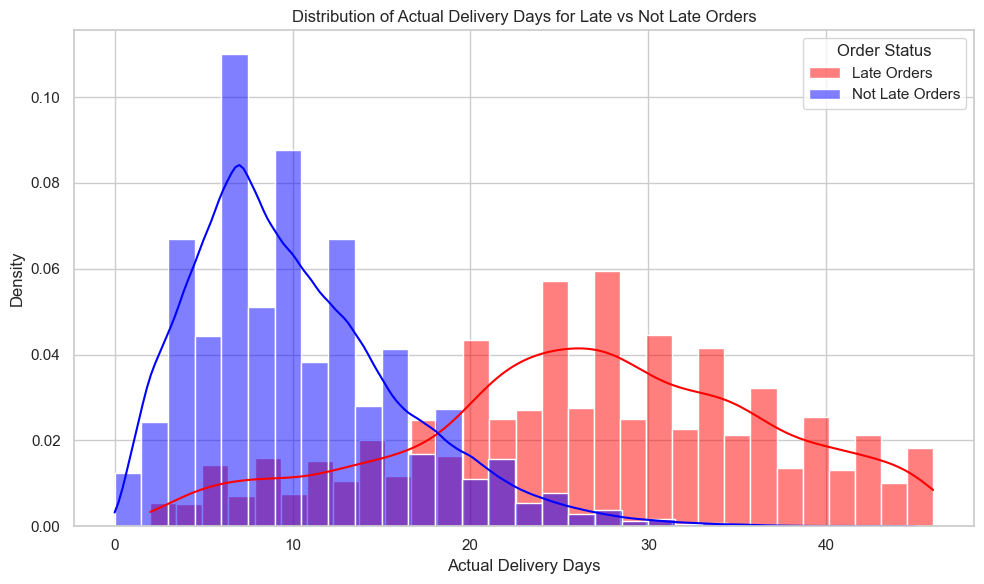

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

late_orders = order_items[order_items['is_late'] == 1]
not_late_orders = order_items[order_items['is_late'] == 0]

plt.figure(figsize=(10, 6))
sns.histplot(late_orders['actual_delivery_days'], bins=30, kde=True, color='red', label='Late Orders', stat="density")
sns.histplot(not_late_orders['actual_delivery_days'], bins=30, kde=True, color='blue', label='Not Late Orders', stat="density")

plt.title('Distribution of Actual Delivery Days for Late vs Not Late Orders')
plt.xlabel('Actual Delivery Days')
plt.ylabel('Density')
plt.legend(title='Order Status')
plt.tight_layout()
plt.show()


In [ ]:
#It appears that around 20 days is the cutoff, with orders that are not late typically delivered within 20 days, while late orders tend to be delivered after 20 days.

In [ ]:
# If I had more time, I would explore the following ideas:
# Analyze actual_delivery_days by city and country to identify patterns. This could help pinpoint specific post offices or regions that might be responsible for delays.
# Investigate actual_delivery_days by product type to see if certain products have longer delivery times compared to others.
# Make bins for customers city and seller city by size

In [161]:
order_items

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
5       00048cc3ae777c65dbb7d2a0634bc1ea              1   
...                                  ...            ...   
109224  fffbee3b5462987e66fb49b1c5411df2              1   
109226  fffcd46ef2263f404302a634eb57f7eb              1   
109227  fffce4705a9662cd70adb13d4a31832d              1   
109228  fffe18544ffabc95dfada21779c9644f              1   
109229  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
5       ef92defde845ab8450f9d70c526ef70f  6426d21aca402a131fc0a5d0960a3c90   
...                                  ...                               ...   
109224  6f0169f259bb0ff432bfff7d829b9946  213b25e6f54661939f11710a6fddb871   
109226  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
109227  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
109228  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
109229  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  \
0       2017-09-19 09:45:35   58.90          13.29   
2       2018-01-18 14:48:30  199.00          17.87   
3       2018-08-15 10:10:18   12.99          12.79   
4       2017-02-13 13:57:51  199.90          18.14   
5       2017-05-23 03:55:27   21.90          12.69   
...                     ...     ...            ...   
109224  2018-06-28 09:58:03  119.85          20.03   
109226  2018-07-20 04:31:48  350.00          36.53   
109227  2017-10-30 17:14:25   99.90          16.95   
109228  2017-08-21 00:04:32   55.99           8.72   
109229  2018-06-12 17:10:13   43.00          12.79   

                             customer_id order_day_of_week  order_hour  ...  \
0       3ce436f183e68e07877b285a838db11a         Wednesday           8  ...   
2       6489ae5e4333f3693df5ad4372dab6d3            Sunday          14  ...   
3       d4eb9395c8c0431ee92fce09860c5a06         Wednesday          10  ...   
4       58dbd0b2d70206bf40e62cd34e84d795          Saturday          13  ...   
5       816cbea969fe5b689b39cfc97a506742            Monday          21  ...   
...                                  ...               ...         ...  ...   
109224  11a0e041ea6e7e21856d2689b64e7f3a           Tuesday           9  ...   
109226  84c5d4fbaf120aae381fad077416eaa0          Saturday          10  ...   
109227  29309aa813182aaddc9b259e31b870e6            Monday          17  ...   
109228  b5e6afd5a41800fdf401e0272ca74655            Monday          23  ...   
109229  96d649da0cc4ff33bb408b199d4c7dcf          Saturday          17  ...   

        total_freight_price   product_category_name  product_weight_g  \
0                     13.29              cool_stuff             650.0   
2                     17.87        moveis_decoracao            3050.0   
3                     12.79              perfumaria             200.0   
4                     18.14      ferramentas_jardim            3750.0   
5                     12.69   utilidades_domesticas             450.0   
...                     ...                     ...               ...   
109224                20.03         casa_construcao            1050.0   
109226                36.53  informatica_acessorios            8950.0   
109227                16.95           esporte_lazer             967.0   
109228                 8.72  informatica_acessorios       

In [165]:
numerical_features = [
    'price', 'freight_value',
    'distance_km', 'item_count', 'total_price', 'total_freight_price',
    'product_weight_g', 'product_length_cm', 'product_height_cm',
    'product_width_cm', 'product_volume_cm3', 'total_weight',
    'late_deliveries', 'avg_delivery_time'
]

categorical_features = ['order_day_of_week', 'order_hour', 'product_category_name']
df = order_items.copy()
df = df[numerical_features+categorical_features+['actual_delivery_days']]
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

X = df_encoded.drop(columns='actual_delivery_days')
y = df_encoded['actual_delivery_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Trial will choose values between 3 and 10
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),  # Learning rate between 0.01 and 0.2
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Number of trees
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Subsampling ratio
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),  # Feature fraction
        'gamma': trial.suggest_float('gamma', 0, 5),  # Regularization term
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Minimum sum of instance weight
    }

    model = xgb.XGBRegressor(**param)

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE with best parameters: {rmse}")

[I 2024-12-05 09:54:12,856] A new study created in memory with name: no-name-937293b4-a0b8-4397-9699-d56ab00e9a73
[I 2024-12-05 09:54:18,516] Trial 0 finished with value: 6.0469624229588 and parameters: {'max_depth': 5, 'learning_rate': 0.06287894026939944, 'n_estimators': 119, 'subsample': 0.9887128207857223, 'colsample_bytree': 0.7874164159003804, 'gamma': 4.505992994562003, 'min_child_weight': 7}. Best is trial 0 with value: 6.0469624229588.
[I 2024-12-05 09:54:35,051] Trial 1 finished with value: 5.891324378961459 and parameters: {'max_depth': 9, 'learning_rate': 0.024323763820543368, 'n_estimators': 274, 'subsample': 0.9263574861554077, 'colsample_bytree': 0.7812942761665015, 'gamma': 1.8808918248621065, 'min_child_weight': 2}. Best is trial 1 with value: 5.891324378961459.
[I 2024-12-05 09:54:40,944] Trial 2 finished with value: 6.024475558712699 and parameters: {'max_depth': 4, 'learning_rate': 0.1781493268829559, 'n_estimators': 182, 'subsample': 0.7888652777074269, 'colsample_

Best hyperparameters: {'max_depth': 9, 'learning_rate': 0.024323763820543368, 'n_estimators': 274, 'subsample': 0.9263574861554077, 'colsample_bytree': 0.7812942761665015, 'gamma': 1.8808918248621065, 'min_child_weight': 2}
Final RMSE with best parameters: 5.817490876295441


In [167]:
# just to show the predictions on the data:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
df_res = order_items.merge(
    orders[['order_id','order_purchase_timestamp']],
    on='order_id')

df_res['predicted_delivery_date'] = pd.to_datetime(df_res['order_purchase_timestamp']) + pd.to_timedelta(best_model.predict(X), unit='D')

df_res[['order_purchase_timestamp', 'predicted_delivery_date']].head()


order_purchase_timestamp       predicted_delivery_date
0      2017-09-13 08:59:02 2017-09-22 18:33:59.839355468
1      2018-01-14 14:33:31 2018-01-23 22:26:05.037475585
2      2018-08-08 10:00:35 2018-08-17 15:40:11.150512693
3      2017-02-04 13:57:51 2017-02-22 13:58:39.944091792
4      2017-05-15 21:42:34 2017-05-23 05:31:09.744018558

In [168]:
df_res['order_purchase_timestamp'] = pd.to_datetime(df_res['order_purchase_timestamp'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

merged_df = pd.merge(orders[['order_id', 'order_estimated_delivery_date']], df_res[['order_id', 'predicted_delivery_date']], on='order_id', how='left')
merged_df['day_diff'] = (merged_df['predicted_delivery_date'] - merged_df['order_estimated_delivery_date']).dt.days
merged_df = merged_df.dropna()
rmse = np.sqrt(mean_squared_error(merged_df['day_diff'], np.zeros_like(merged_df['day_diff'])))
print(f"RMSE between predicted and actual delivery date differences: {rmse}")


RMSE between predicted and actual delivery date differences: 14.394347810018749


In [127]:
# Our model achieved an RMSE of 5.8 (days), compared to the baseline RMSE of 14.39 (days).
# A lower RMSE value indicates a better model, as it means the model's predictions are closer to the actual values.

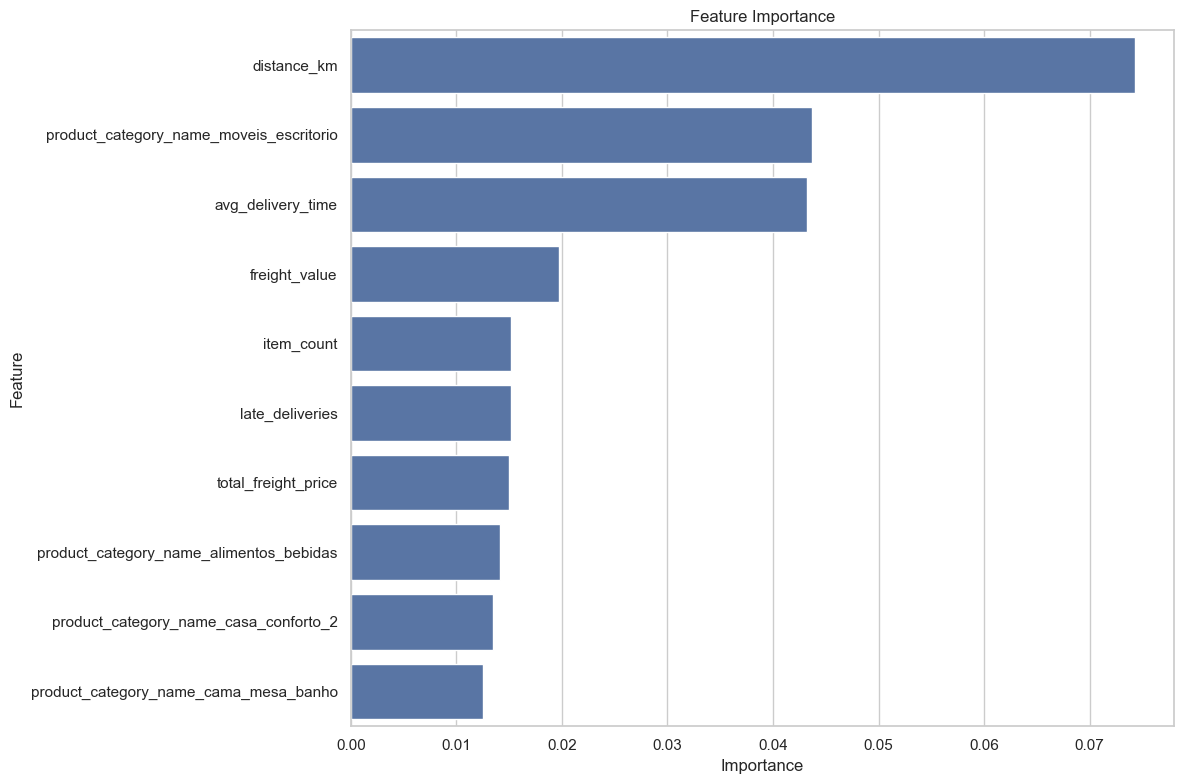

In [169]:
# Feature importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Questions for the Product Manager:

- What is shipping_limit_date? can we use this to make more features like time untill this date?
- Do we have any benchmarks for seller performance in terms of delivery times? Are there actions we’re taking to help sellers with longer delivery times improve?

- How do we handle logistics for distant locations? Are there specific factors (like carrier limitations or warehouse locations) that contribute to longer delivery times in those areas?

- Can we set some targets for the "approval-to-delivery" duration? Is there an ideal range for this metric?

- Are there any strategies to optimize freight costs? Do we have any goals around the relationship between product price, freight value, and delivery performance?

- Are there any pricing strategies in place to encourage faster delivery times?

- Are we prioritizing certain sellers based on their delivery times or service levels? Do we have KPIs in place to track and support sellers that need help?

- Can we track the reasons for orders that are consistently late (over 20 days)?


### Recommendations:

- We could focus on identifying sellers who consistently have higher average delivery times.

- Consider optimizing logistics for sellers who frequently ship to distant locations. This could involve partnering with more efficient shipping carriers or offering discounts for expedited deliveries to high-priority regions.

- It might be useful to identify specific types of products (especially large or fragile items) that consistently lead to delays.

- Investigating the causes behind late orders (e.g., delays at the warehouse, customs issues, or carrier problems) could provide valuable insights for improving delivery times.


### What can we expect in production?

1. **Model Deployment**:
   After training, the XGBoost model will be deployed to make predictions on new data. This means it’ll predict delivery times or other target variables for incoming orders.

2. **Data Handling**:
   The data pipeline will handle incoming data from multiple sources (like sellers or logistics systems). We’ll need to clean any missing or inconsistent data and make sure features are processed correctly for the model.

3. **Model Monitoring**:
   Once the model is live, we’ll keep an eye on its performance. We’ll track its accuracy(RMSE in this case), check for any changes in the input data (data drift), and make sure it stays reliable. If it starts underperforming, we may need to retrain it or tweak it.

4. **Business Impact**:
   The model will help optimize processes by identifying high-risk orders that may be delayed or flagging sellers with slower delivery times. This lets the team take action before things go wrong.

5. **User Interaction**:
   Depending on how the system is set up, business users (like sales or logistics teams) will interact with the model’s predictions. For example, if the model predicts delays, they can adjust shipping or inform customers ahead of time.

6. **Scalability**:
   As we get more data (new sellers, regions, etc.), the system will need to handle it. This might mean adding new features or adjusting the model to keep things running smoothly.

7. **Feedback Loop**:
   We'll compare the model's predictions to actual outcomes (e.g., was the delivery late or on time?). This feedback will help us improve the model over time.

8. **Performance Optimization**:
   Depending on the setup (cloud, on-premise), we might need to optimize the system to make predictions quickly, especially if we’re doing real-time predictions for a lot of orders.


### Plan for Recommending Alternatives to Shorten Shipping Times

#### Step 1: **Add to EDA and Model Evaluation:**
1. **Group by Sellers and Regions**:
   - Use average delivery time and late delivery rate (`is_late`) for each seller, city, and state.
   - Identify sellers and regions with consistently faster delivery times.

2. **Product Analysis**:
   - Analyze the `product_category_name` to identify categories with shorter delivery times.
   - Find products in the same category that are delivered faster in similar regions.

3. **Feature Importance**:
   Identify the key drivers of delivery time using the available numerical and categorical features. Focus on features like `seller_state`, `distance_km`, `avg_delivery_time`, and `product_category_name` to find patterns in the data.

---

#### Step 2: **Recommendation Logic**
   For orders predicted to have long delivery times:
   - Suggest alternative products in the same category (`product_category_name`) from sellers with lower `avg_delivery_time` and `late_deliveries`.
   - Prioritize products shipped from closer locations (`seller_city`, `seller_state`) to the customer.
   - Use `customer_city` and `customer_state`.
   - Factor in regions with faster average delivery times (`distance_km`).
   - Focus on recommendations with competitive `price` and reasonable `freight_value` to balance cost and delivery performance.
   - Highlight the trade-off between faster delivery and higher freight costs, if applicable.
   - Use a threshold, such as 20 days for `actual_delivery_days`, to flag orders likely to be late.
   - Suggest alternatives only for flagged orders.

#### Step 3: **Evaluate Recommendations**
   - Test the recommendation system by analyzing whether suggested alternatives would have reduced the delivery time in historical data.
   - Measure success by comparing the average delivery times before and after applying recommendations.
   - Track customer acceptance rates of the recommended alternatives.
   - Use feedback to refine the recommendation logic over time.

---

#### Example Use Case
- **Current Order**:
   - Product: "casa_conforto_2"
   - Seller: Slow Seller A
   - Predicted Delivery Time: 25 days

- **Recommendation**:
   - Alternative products in "casa_conforto_2" category from sellers with `avg_delivery_time < 15 days`.
   - Highlight products from nearby states or cities with faster logistics.
